In [ ]:
!pip install torchsummary
!pip install warmup_scheduler

  Preparing metadata (setup.py) ... - done
  Created wheel for warmup_scheduler: filename=warmup_scheduler-0.3-py3-none-any.whl size=2969 sha256=04e1dc6383f79ffe1200dc9ba9861b906481eca212bedcfd19376164f7450a1e
  Stored in directory: /root/.cache/pip/wheels/59/01/9e/d1820991c32916e9808c940f572b462f3e46427f3e76c4d852
Successfully built warmup_scheduler


In [ ]:
import os
import math
import time
import shutil
import pickle

import argparse
import requests
import os.path as osp
import numpy as np
import pandas as pd
from   warmup_scheduler import GradualWarmupScheduler

from collections import OrderedDict, Counter

import zipfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV

import torch
import torchvision
from   torchvision import datasets
from   torchvision import transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from   torch.utils.data import Dataset
from   torch.utils.data.dataset import ConcatDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from   torch.optim.lr_scheduler import StepLR
import torch.multiprocessing as mp
import torch.optim.lr_scheduler as lr_scheduler

from tqdm.notebook import tqdm


import pickle
from PIL import Image
from itertools import islice

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import warnings
from tqdm.notebook import tqdm

import torchsummary
from torchsummary import summary

# Ignore all warnings
warnings.filterwarnings("ignore", category=Warning)
%matplotlib inline

from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_on_gpu = torch.cuda.is_available() ## it will return True or False

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [ ]:
train_images_path = '/kaggle/working/extracted_files/train_set'
test_images_path  = '/kaggle/working/extracted_files/val_set'

In [ ]:
# Define the path to the zip file (adjust the path as necessary)
val_zip_path = '/kaggle/input/ifood-2019-fgvc6/val_set.zip'

# Define the directory where you want to extract the contents
extract_dir = '/kaggle/working/extracted_files'

# Create the extraction directory if it does not exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(val_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    print(f'Extracted all files to {extract_dir}')

# Verify extraction
extracted_files = os.listdir(extract_dir)
print('Extracted files:', extracted_files)

Extracted all files to /kaggle/working/extracted_files
Extracted files: ['val_set']


In [ ]:
# the path to the zip file
train_zip_path = '/kaggle/input/ifood-2019-fgvc6/train_set.zip'

# the directory where we want to extract the contents
extract_dir    = '/kaggle/working/extracted_files'

# Create the extraction directory if it does not exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    print(f'Extracted all files to {extract_dir}')

# Verify extraction
extracted_files = os.listdir(extract_dir)
print('Extracted files:', extracted_files)

Extracted all files to /kaggle/working/extracted_files
Extracted files: ['val_set', 'train_set']


In [ ]:
# Check the count of images in train set
train_files = os.listdir( extract_dir + '/train_set' )
print(f'Number of train images = {len(train_files)}')

# Check the count of images in validation set
val_files = os.listdir( extract_dir + '/val_set' )
print(f'Number of validation images = {len(val_files)}')

Number of train images = 118475
Number of validation images = 11994


In [ ]:
### READ LABLES ANNOTATIONS FILE AND CONVERT IT INTO DICTIONARY
annot = '/kaggle/input/ifood-2019-fgvc6/class_list.txt'
f = open( annot, "r" )
labels_dict = { int(x.split(' ')[0]) : x.split(' ')[1].split('\n')[0] for x in f }

In [ ]:
## Read train df
train_df = pd.read_csv( '/kaggle/input/ifood-2019-fgvc6/train_labels.csv' )
print(train_df.shape)
train_df.head(6)

(118475, 2)


,img_name,label
0,train_101733.jpg,211
1,train_101734.jpg,211
2,train_101735.jpg,211
3,train_101736.jpg,211
4,train_101737.jpg,211
5,train_101738.jpg,211


In [ ]:
# Shuffle DataFrame rows
train_df = train_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
train_df.head(6)

(118475, 2)


,img_name,label
0,train_043314.jpg,190
1,train_025438.jpg,171
2,train_010544.jpg,67
3,train_060871.jpg,181
4,train_011710.jpg,31
5,train_103544.jpg,214


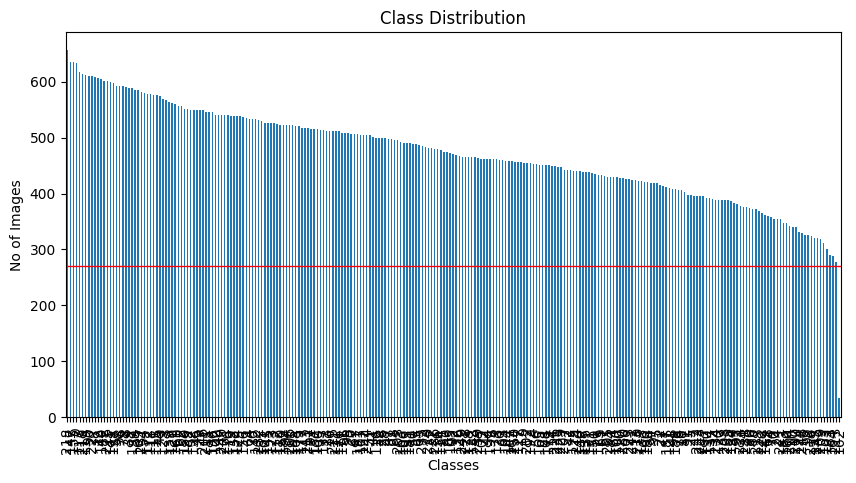

In [ ]:
## Plotting the class distribution
no_of_samples_per_class = 270
plt.figure( figsize = (10, 5) )
train_df['label'].value_counts().plot( kind = 'bar' )
plt.xlabel('Classes')
plt.ylabel('No of Images')
plt.title('Class Distribution')
# Draw a horizontal line at y = 100
plt.axhline( y = no_of_samples_per_class, color = 'r', linestyle = '-', linewidth = 1 )
plt.show()

In [ ]:
### 162 CLASS HAS ONLY 34 DATA ITEMS, WILL DROP THIS

train_df[train_df['label'] == 162].shape

(34, 2)

In [ ]:
### 251 TOTAL CLASSES
len(train_df['label'].unique())

251

In [ ]:
### HERE WE ARE TAKING 270 IMAGES FOR EACH CLASS AND DROPPING THE CLASS WITH < 270 IMAGES

def take_samples_per_class( train_df, no_of_samples ):
    dropped_columns = []
    df = pd.DataFrame()
    for i in range(251):
        if train_df[ train_df['label'] == i ].shape[0] >= no_of_samples:
            df_ = train_df[ train_df['label'] == i ].iloc[:no_of_samples]
            df  = pd.concat( [df, df_], ignore_index = True )
        else:
            # print('Dropped class -- ',i,'--',labels_dict[i])
            dropped_columns.append(i)
    return df, dropped_columns

df, dropped_columns = take_samples_per_class( train_df, no_of_samples_per_class )
print(f'Dropped columns = {dropped_columns}')
print(df.shape)
df.head(3)

Dropped columns = [162]
(67500, 2)


,img_name,label
0,train_059498.jpg,0
1,train_059637.jpg,0
2,train_059583.jpg,0


In [ ]:
# Shuffle DataFrame rows
df = df.sample(frac=1).reset_index(drop=True)
df.head(6)

,img_name,label
0,train_003383.jpg,166
1,train_004234.jpg,100
2,train_046117.jpg,144
3,train_064888.jpg,158
4,train_045477.jpg,76
5,train_034369.jpg,66


In [ ]:
###  TOTAL CLASSES AFTER CLASS BALANCING 250
num_classes = len(df['label'].unique())
num_classes

250

In [ ]:
## WE DROPPED 162 CLASS, NOW WE HAVE TO ADJUST THE LABELS
sorted(df['label'].unique())[160:174]

[160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174]

In [ ]:
# Function to adjust labels
def adjust_labels(label):
    if label >= 163:
        return label - 1
    else:
        return label

df['labels'] = df['label'].apply(adjust_labels)
sorted(df['labels'].unique())[160:174]

[160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173]

In [ ]:
print(len(df['label'].unique()))
df.head(2)

250


,img_name,label,labels
0,train_003383.jpg,166,165
1,train_004234.jpg,100,100


In [ ]:
## HERE WE ARE TAKING THE VALIDATION DATA DROM TRAIN SET
def train_and_val_split_func( df ):
    train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['labels'], random_state=42)
    print(f'train set  = {train_df.shape} --- {(train_df.shape[0]/df.shape[0])*100}')
    print(f'valid set  = {val_df.shape} --- {(val_df.shape[0]/df.shape[0])*100}')

    return train_df.reset_index().drop('index', axis =1), val_df.reset_index().drop('index', axis =1)

In [ ]:
## Preprocessing test df
test_df_ = pd.read_csv( '/kaggle/input/ifood-2019-fgvc6/val_labels.csv' )
test_df_ = test_df_[ test_df_['label'] != 162 ] ### DROP 162 CLASS

print('Before Processing: ',sorted(test_df_['label'].unique())[160:174])
test_df_['labels'] = test_df_['label'].apply(adjust_labels) ## fix the classes
print('After Processing:  ',sorted(test_df_['labels'].unique())[160:174])

Before Processing:  [160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174]
After Processing:   [160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173]


In [ ]:
## train and validation df
train_df_, val_df_ = train_and_val_split_func( df )
print(f'test  set  = {test_df_.shape}')

train set  = (57375, 3) --- 85.0
valid set  = (10125, 3) --- 15.0
test  set  = (11945, 3)


In [ ]:
train_df_.head(5)

,img_name,label,labels
0,train_110953.jpg,230,229
1,train_109196.jpg,226,225
2,train_066279.jpg,176,175
3,train_003259.jpg,166,165
4,train_073484.jpg,187,186


In [ ]:
train_images_path = '/kaggle/working/extracted_files/train_set'
test_images_path  = '/kaggle/working/extracted_files/val_set'

#########################################################################################
#########################################################################################

## Create the Jigsaw Puzzle

### 1. Get Permutations

In [ ]:
import itertools
import random
import numpy as np

from scipy.spatial.distance import hamming

In [ ]:
# Build list of all possible permutations
permuts_list  = list( itertools.permutations( range(9) ) )
permuts_array = np.array(permuts_list)
no_permuts    = len(permuts_list)

In [ ]:
# Take top x permutations which have max average hamming distance
permuts_to_take = 200
set_of_taken    = set()
cnt_iterations  = 0

while True:
    cnt_iterations += 1
    x = random.randint(1, no_permuts - 1)
    y = random.randint(1, no_permuts - 1)
    permut_1 = permuts_array[x]
    permut_2 = permuts_array[y]
    hd = hamming(permut_1, permut_2)

    if hd > 0.9 and (not x in set_of_taken) and (not y in set_of_taken):
        set_of_taken.add(x)
        set_of_taken.add(y)

        if len(set_of_taken) == permuts_to_take:
            break

    if cnt_iterations % 100 == 0:
        print ("Already performed count of iterations with pairs of jigsaw permutations", cnt_iterations)
        print ("Length of set of taken: ",len(set_of_taken))


Already performed count of iterations with pairs of jigsaw permutations 100
Length of set of taken:  72
Already performed count of iterations with pairs of jigsaw permutations 200
Length of set of taken:  142


In [ ]:
print ("No of iterations it took to build top - {} permutations array = {}".format(permuts_to_take, cnt_iterations))
print ("No of permutations", len(set_of_taken))

No of iterations it took to build top - 200 permutations array = 272
No of permutations 200


In [ ]:
# Build the array for selected permutation indices above
selected_permuts = []
for ind, perm_id in enumerate(set_of_taken):
    if ind < 10:
        print ("Sample permutation {}".format(ind))
        print (permuts_array[perm_id])
    selected_permuts.append(permuts_array[perm_id])

selected_permuts = np.array(selected_permuts)
# np.save('Selected_permuts.npy', selected_permuts)

Sample permutation 0
[8 1 3 2 5 4 6 7 0]
Sample permutation 1
[5 2 6 7 0 1 4 3 8]
Sample permutation 2
[3 7 6 2 8 0 5 1 4]
Sample permutation 3
[0 2 4 3 6 7 5 1 8]
Sample permutation 4
[2 1 7 4 6 5 8 3 0]
Sample permutation 5
[1 0 7 8 3 5 2 4 6]
Sample permutation 6
[1 3 4 6 2 7 5 8 0]
Sample permutation 7
[2 1 0 5 8 6 4 7 3]
Sample permutation 8
[4 3 1 0 6 2 5 8 7]
Sample permutation 9
[5 3 1 8 6 7 0 2 4]


In [ ]:
# Data files which will get referred
# permuts_file_path = 'selected_permuts.npy'

In [ ]:
# fi = np.load( permuts_file_path )
permuts_file = selected_permuts

In [ ]:
permuts_file[0]

array([8, 1, 3, 2, 5, 4, 6, 7, 0])

### Dataset Class

In [ ]:
def get_transform( train = True ):
    if train:
        transform = transforms.Compose([
                    transforms.RandomCrop( 256, padding = 4 ),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize( (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261) )
        ])
    else:
        transform = transforms.Compose([
                    transforms.Resize( (256, 256) ),
                    transforms.ToTensor(),
                    transforms.Normalize( (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261) )
        ])

    return transform

In [ ]:
class MyDatasetClass(Dataset):

    def __init__( self, dir_path, labels_df, transform ):
        # self.labels_df = pd.read_csv( labels_csv )
        self.labels_df = labels_df
        self.dir_path  = dir_path
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):

        cur_index  = self.labels_df.iloc[idx]

        img_path = os.path.join( self.dir_path, cur_index[0])  # image path
        img      = Image.open(img_path).convert('RGB')

        ## apply transform
        transformed     = self.transform( img )

        return transformed.to(torch.float32), cur_index[2]

In [ ]:
train_images_path = '/kaggle/working/extracted_files/train_set'
test_images_path  = '/kaggle/working/extracted_files/val_set'

In [ ]:
## HERE -- TESTING THE DATALOADER CLASS
ds = MyDatasetClass( train_images_path, train_df_, transform = get_transform( train = True ) )

inp, out = ds.__getitem__( 5 )          # get first item
print(f'input shape -- {inp.shape} --- {inp.dtype}') # print shapes
print(f'output      -- {out}       --- {out.dtype}')

input shape -- torch.Size([3, 256, 256]) --- torch.float32
output      -- 104       --- int64


## JigsawPuzzle Dataset

In [ ]:
def crop_from_center(pil_image, new_h, new_w):
#     print(f'Inside function crop_from_center:')

    width, height = pil_image.size  # Get dimensions

    left = (width - new_w) / 2
    top = (height - new_h) / 2
    right = (width + new_w) / 2
    bottom = (height + new_h) / 2

    # Crop the center of the image
    pil_image = pil_image.crop((left, top, right, bottom))

    return pil_image

In [ ]:
def get_nine_crops(pil_image):
    """
    Get nine crops for a square pillow image. That is height and width of the image should be same.
    :param pil_image: pillow image
    :return: List of pillow images. The nine crops
    """

#     print(f'Inside function get_nine_crops:')
    w, h = pil_image.size
    diff = int(w/3)

    r_vals = [0, diff, 2 * diff]
    c_vals = [0, diff, 2 * diff]

    list_patches = []

    for r in r_vals:
        for c in c_vals:

            left = c
            top = r
            right = c + diff
            bottom = r + diff

            patch = pil_image.crop((left, top, right, bottom))
            list_patches.append(patch)

    return list_patches

In [ ]:
# Define data transforms
data_transform_js = transforms.Compose([
                    transforms.RandomCrop((64, 64)),
                    transforms.ColorJitter(brightness=[0.5, 1.5]),
                    transforms.ToTensor(),
                    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ])

In [ ]:
from IPython.display import display

In [ ]:
class GetJigsawPuzzleDataset(Dataset):

    def __init__( self, dir_path, labels_df, avail_permuts_file_path, range_permut_indices = None, transform = None ):

        self.dir_path      = dir_path
        self.labels_df     = labels_df

        self.transform     = transform

        self.permuts_avail = avail_permuts_file_path ## shape -- 200,9
        self.range_permut_indices = range_permut_indices ## [ 0,9 ]

#       print(f'file_paths -- {self.dir_path}')
#       print(f'range_permut_indices -- {range_permut_indices}')

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, index):

        cur_index = self.labels_df.iloc[index]
#         print(f'cur_index -- {cur_index}')
#         print('*'*10)
#         print(cur_index[0])
#         print(cur_index[2])
#         print(cur_index[-1])

        cl_target = cur_index[-1]

        img_path = os.path.join( self.dir_path, cur_index[0] )  # image path
#         print(f'image_path --- {img_path}')

        pil_image = Image.open(img_path)
#         print(f'image size --- {pil_image.size}')

        # Check if image has only single channel. If True, then swap with 0th image
        # Assumption 0th image has got 3 number of channels
        if len(pil_image.getbands()) != 3:
#             print('INSIDE THE IF CONDITION OF CHANNELS')
            file_path = self.file_paths[0]
            pil_image = Image.open(file_path)

        # Convert image to torch tensor
        pil_image = pil_image.resize((256, 256))
#         print(f'image resize --- {pil_image.size}')

#         display(pil_image)

        # Crop from center
        pil_image  = crop_from_center(pil_image, 225, 225)
#         print(f'image resize after crop --- {pil_image.size}')
#         display(pil_image)

        # Get nine crops for the image
        nine_crops = get_nine_crops(pil_image)
#         print(f'nine_crops -- {nine_crops}')

        # Permut the 9 patches obtained from the image
        if self.range_permut_indices:
            ## returns an int between 0 and 9
            permut_ind = random.randint( self.range_permut_indices[0], self.range_permut_indices[1] )
#             print(f'permut_ind --- {permut_ind}')
        else:
            permut_ind = random.randint( 0, len(self.permuts_avail) - 1)

        permutation_config   = self.permuts_avail[permut_ind] # list of permuations [0,3,1,4,2,6,8,7,9,5]
#         print(f'permutation_config   --- {permutation_config}')

        permuted_patches_arr = [None] * 9
#         print(f'permuted_patches_arr --- {permuted_patches_arr}')

        for crop_new_pos, crop in zip( permutation_config, nine_crops ):
#             print(crop_new_pos, crop)
            permuted_patches_arr[ crop_new_pos ] = crop
#         print(f'permuted_patches_arr ---')
#         for patch in permuted_patches_arr:
#             print(patch)

        # TODO: Remove hard coded values from here
        tensor_patches = torch.zeros(9, 3, 64, 64)

        for ind, jigsaw_patch in enumerate(permuted_patches_arr):
#             print(f'*****************************')
            jigsaw_patch_tr = self.transform(jigsaw_patch)
#             print(f'*****************************')
            tensor_patches[ind] = jigsaw_patch_tr
#         print(f'*****************************')

        return tensor_patches, permut_ind, cl_target

In [ ]:
## testing the jigsaw puzzle class
for st_perm_ind in range( 0, 200, 10 ):

    print(f'st_perm_ind --- {st_perm_ind}')
    ds = GetJigsawPuzzleDataset( train_images_path, train_df_, permuts_file,
                                 range_permut_indices = [ st_perm_ind, st_perm_ind + 9 ],
                                 transform = data_transform_js )

    inp, out, target = ds.__getitem__( 5 )
    print(f'input shape -- {inp.shape} --- {inp.dtype}')
    print(f'output      -- {out}')
    print(f'target      -- {target}')

    break

st_perm_ind --- 0
input shape -- torch.Size([9, 3, 64, 64]) --- torch.float32
output      -- 4
target      -- 104


## DataLoaders

In [ ]:
batch_size = 20

def data_loader( images_path, df ):
    return  DataLoader(
            ConcatDataset( [ GetJigsawPuzzleDataset( images_path, df, permuts_file,
                             range_permut_indices = [ st_perm_ind, st_perm_ind + 9 ],
                             transform = data_transform_js )
                             for st_perm_ind in range(0, 200, 10) ] ),
            batch_size  = batch_size,
            shuffle     = True,
            num_workers = 8
            )

In [ ]:
train_loader = data_loader( train_images_path, train_df_ )
valid_loader = data_loader( train_images_path,   val_df_ )
test_loader  = data_loader( test_images_path,   test_df_ )

In [ ]:
print(f'train loader len: {len(train_loader)}')
print(f'valid loader len: {len(valid_loader)}')
print(f'test loader len:  {len(test_loader)}')

train loader len: 57375
valid loader len: 10125
test loader len:  11945


In [ ]:
for i, (images, out, target) in enumerate(valid_loader):
    print(images.shape)
    print(out.shape)
    print(target.shape)
    break

torch.Size([20, 9, 3, 64, 64])
torch.Size([20])
torch.Size([20])


In [ ]:
out

tensor([132, 123,   4, 112, 182, 151, 103, 157,  45, 148, 119, 139, 104,  36,
         83,  81, 176, 106, 105, 104])

In [ ]:
target

tensor([219,  83,  67,  74,  78, 201,   5,  90, 134,  82, 247, 203, 160, 100,
        229,  38, 184,   0, 218, 238])

## FINAL

In [ ]:
class GigsawPuzzleClassFinal(nn.Module):

    metrics     = ['Loss', 'Acc1']
    metrics_fmt = [':.4e', ':6.2f']

    def __init__( self, n_classes ):
        super().__init__()
        self.model      = NetworkInNetwork()
        self.latent_dim = 1728
        self.feat_layer = 'conv2'
        self.n_classes  = n_classes # 250

    def construct_classifier(self): ## use the features from the gigsaw model
        classifier = nn.Sequential(
          # affine = False means no learnable parameters for scaling and shifting
          nn.BatchNorm1d( self.latent_dim, affine = False ),
          nn.Linear(      self.latent_dim, self.n_classes )
        )
        return classifier

    def forward(self, images, targets): # images -> [20, 9, 3, 64, 64], [20]
        batch_size      = images.shape[0] # 20
#         print(f'This is the batch size in the forward function: {batch_size}')

#         images, targets = self._preprocess(images)
#         print(f'Shape of the images:  {images.shape}')  # [80, 3, 256, 256]
#         print(f'Shape of the targets: {targets.shape}') # [80]

        targets    = targets.to( images.get_device() ) ## true labels

        logits, zs = self.model( images, out_feat_keys = ['classifier', self.feat_layer] ) ## features of ['classifier', 'conv2']
        # zs     --> features of conv2 layer      -- [20, 1728]
        # logits --> features of classifier layer -- [20, 200 ]
#         print(f'zs shape: {zs.shape}')
#         print(f'Logits shape: {logits.shape}')
#         print(f'targets: {targets}')
#         print(f'targets dtype --{targets.dtype}')

        loss    = F.cross_entropy( logits, targets )

        pred    = logits.argmax( dim = -1 )
#         print(f'predictions --- {pred}')

        correct = pred.eq(targets).float().sum() ### total no of correct predictions
#         print(f'correct --- {correct}')
        acc     = correct / targets.shape[0] * 100.
#         print(f'accuracy --- {acc}')

#         ## starting 128 images are 0 degrees ( actual images )
#         zs = zs[ :batch_size ]           ## zs.shape --> torch.Size([128, 192, 8, 8])
#         zs = zs.flatten( start_dim = 1 ) ## torch.Size([128, 12288])

        return dict( Loss = loss, Acc1 = acc ), zs[ :batch_size ] ## torch.Size([128, 12288])

    # this function will only returns the features of conv2 layer
    def encode(self, images, flatten=True):
        zs = self.model( images, out_feat_keys = (self.feat_layer,) )
        return zs.flatten( start_dim = 1 )

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super(BasicBlock, self).__init__()

        padding     = ( kernel_size - 1 ) // 2
        self.layers = nn.Sequential()

        self.layers.add_module('Conv', nn.Conv2d( in_planes, out_planes, kernel_size=kernel_size, stride=2, padding=1, bias=False ) )
        self.layers.add_module('BatchNorm', nn.BatchNorm2d(out_planes))
        self.layers.add_module('ReLU',      nn.ReLU(inplace=True))

    def forward(self, x):
        return self.layers(x)

In [ ]:
class GlobalAveragePooling(nn.Module):
    def __init__(self):
        super(GlobalAveragePooling, self).__init__()

    def forward(self, feat):
        num_channels = feat.size(1)
        return F.avg_pool2d(feat, (feat.size(2), feat.size(3))).view(-1, num_channels)

In [ ]:
class NetworkInNetwork(nn.Module):

    def __init__(self):
        super(NetworkInNetwork, self).__init__()

        num_classes      = 200
        num_inchannels   = 3
        num_stages       = 4
        use_avg_on_conv3 = False

        self.siamese_deg = 9

        nChannels  = 6
        nChannels2 = 12
        nChannels3 = 24
        nChannels4 = 48
        nChannels5 = 96
        nChannels6 = 192

        blocks = [ nn.Sequential() for i in range(5) ]
        # print(f'blocks: {blocks}')

        # 1st block
        blocks[0].add_module('Block1_ConvB1', BasicBlock(num_inchannels, nChannels, kernel_size=3 ))
        blocks[0].add_module('Block1_ConvB2', BasicBlock(nChannels,  nChannels2, kernel_size=3))
        blocks[0].add_module('Block1_ConvB3', BasicBlock(nChannels2, nChannels3, kernel_size=3))
#         blocks[0].add_module('Block1_MaxPool', nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

        # 2nd block
        blocks[1].add_module('Block2_ConvB1',  BasicBlock(nChannels3, nChannels4, kernel_size=3))
#         blocks[1].add_module('Block2_ConvB2',  BasicBlock(nChannels4,  nChannels5, kernel_size=3))
#         blocks[1].add_module('Block2_ConvB3',  BasicBlock(nChannels5,  nChannels6, kernel_size=3))
#         blocks[1].add_module('Block2_AvgPool', nn.AvgPool2d(kernel_size=3,stride=2,padding=1))

        # 3rd block
        blocks[2].add_module('Block3_ConvB1',  BasicBlock(nChannels4, nChannels5, 3))
#         blocks[2].add_module('Block3_ConvB2',  BasicBlock(nChannels6, nChannels6, 1))
#         blocks[2].add_module('Block3_ConvB3',  BasicBlock(nChannels6, nChannels6, 1))

#         if num_stages > 3 and use_avg_on_conv3:
#             blocks[2].add_module('Block3_AvgPool', nn.AvgPool2d(kernel_size=3,stride=2,padding=1))

        for s in range(3, num_stages):
            blocks[s].add_module('Block'+str(s+1)+'_ConvB1',  BasicBlock(nChannels5, nChannels6, 3))
#             blocks[s].add_module('Block'+str(s+1)+'_ConvB2',  BasicBlock(nChannels6, nChannels6, 1))
#             blocks[s].add_module('Block'+str(s+1)+'_ConvB3',  BasicBlock(nChannels6, nChannels6, 1))

        ## fully connected layer

        blocks[4].add_module("FC4", nn.Linear( nChannels6, nChannels6 ) )

        # classifier
        blocks.append( nn.Sequential() )
        ### 200 permutations
        blocks[-1].add_module('Classifier', nn.Linear( 1728, 200 )) # nChannels6, num_classes

        self._feature_blocks = nn.ModuleList(blocks)
#         print(f'all feature blocks: {self._feature_blocks}')

        self.all_feat_names = [ 'conv'+str(s+1) for s in range(num_stages) ] + [ 'FC4' ,'classifier']
#         print(f'all_feat_names: --- {self.all_feat_names}')

        assert( len(self.all_feat_names) == len(self._feature_blocks) )

    def forward(self, x, out_feat_keys=None):
        # x: [batch_size, num_patches, channels, height, width]

        # print(f'out_feat_keys --- {out_feat_keys}') # out_feat_keys --- ['classifier', 'conv2']
        out_feat_keys, max_out_feat = self._parse_out_keys_arg(out_feat_keys)
        # print(f'out_feat_keys after parse function --- {out_feat_keys}') # ['classifier', 'conv2']
        # print(f'max_out_feat --- {max_out_feat}') # 5


        out_feats = [None] * len( out_feat_keys ) # 2

        # Placeholder to store feature vectors from each patch
        patch_features = []

        # Iterate over patches
        for patch_index in range(self.siamese_deg): # 9
            patch = x[:, patch_index, :, :, :]  # Extract the patch
            feat = patch
#             print(f'Initial input --- {feat.shape}') # Initial input --- [20, 3, 64, 64]

            # Pass through each feature block
            for f in range(max_out_feat + 1): # 6
                key = self.all_feat_names[f]

#                 # Flatten if classifier is reached
#                 if key == 'classifier':
#                     feat = feat.view(feat.size(0), -1)
#                     print('classifier --- ',feat.shape)

                if key != 'classifier':
#                     print(f'key --- {key}')

                    if key == 'FC4':
                        feat = feat.view(feat.size(0), -1)

                    # Forward through the feature block
                    feat = self._feature_blocks[f](feat)
#                     print('feat --- ',feat.shape)

            patch_features.append(feat)

        # Concatenate feature vectors from all patches
        final_feat_vectors = torch.cat(patch_features, dim=1)
#         print(f'final_feat_vectors --- {final_feat_vectors.shape}') ## [20, 1728]

        # Forward the concatenated vector through the classifier block
        final_output = self._feature_blocks[-1](final_feat_vectors)
#         print(f'final_output gigsaw classifier --- {final_output.shape}') ## [20, 200]

        ## save features and classifier
        #####################################################################
        out_feats[ out_feat_keys.index('conv2') ]      = final_feat_vectors
        out_feats[ out_feat_keys.index('classifier') ] = final_output
        #####################################################################

        out_feats = out_feats[0] if len(out_feats) == 1 else out_feats
#         print(f'out_feats -- { len(out_feats) }')

        return out_feats

    def _parse_out_keys_arg(self, out_feat_keys):
        out_feat_keys = [self.all_feat_names[-1]] if out_feat_keys is None else out_feat_keys

        if len(out_feat_keys) == 0:
            raise ValueError('Empty list of output feature keys.')

        for f, key in enumerate(out_feat_keys):
            if key not in self.all_feat_names:
                raise ValueError(f'Feature with name {key} does not exist. Existing features: {self.all_feat_names}.')
            elif key in out_feat_keys[:f]:
                raise ValueError(f'Duplicate output feature key: {key}.')

        max_out_feat = max([self.all_feat_names.index(key) for key in out_feat_keys])

        return out_feat_keys, max_out_feat

In [ ]:
def unnormalize(images):
    mu     = [ 0.4914, 0.4822, 0.4465 ]
    stddev = [ 0.2023, 0.1994, 0.2010 ]

    mu     = torch.FloatTensor(mu).view(1, 3, 1, 1)
    stddev = torch.FloatTensor(stddev).view(1, 3, 1, 1)
    return images * stddev + mu

In [ ]:
# Computes the accuracy over the k top predictions for the specified values of k

def accuracy( output, target, topk = (1,) ):
    with torch.no_grad():
        maxk       = max(topk)      ## 5
        batch_size = target.size(0) ## 10
#         print(f'This is the batch size: {batch_size}')

        # print('ACCURACY ....................')
        # print(f'output shape: {output.shape}') ## output shape: torch.Size([10, 250]) -- 250 classes
        # print(f'target shape: {target.shape}') ## target shape: torch.Size([10])

        # returns the top 5 predictions for each sample in the batch.
        _, pred = output.topk( maxk, 1, True, True ) # pred --> ( batch_size, maxk ) -- ## torch.Size([10, 5])
        # print(pred.shape)

        # Transpose the Prediction Tensor
        pred    = pred.t() # ( maxk, batch_size ) -- ## torch.Size([5, 10])
        # print(f'shape of pred after transpose: {pred.shape}')

        correct = pred.eq( target.view(1, -1).expand_as(pred) ) #  target.view( 1, -1 ) -- (1, batch_size) -- torch.Size([1, 128])
        ## target.view(1, -1).expand_as(pred) --> output = torch.Size([5, 10])
        ## correct.shape = torch.Size([5, 12])

        res = []
        for k in topk:
            ## take one row, flatten from this torch.Size([1, 12]) to torch.Size([12]), convert into float, sum the values, keep dimension
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append( correct_k.mul_( 100.0 / batch_size ) )
        return res

In [ ]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt  = fmt
        self.reset()

    def reset(self):
        self.val   = 0
        self.avg   = 0
        self.sum   = 0
        self.count = 0

    def update( self, val, n = 1 ):
        self.val    = val
        self.sum   += val * n
        self.count += n
        self.avg    = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [ ]:
class ProgressMeter(object):
    def __init__( self, num_batches, meters, prefix = "" ):
        self.batch_fmtstr = self._get_batch_fmtstr( num_batches ) ## [ {:3d} / 100 ]
        self.meters       = meters
        self.prefix       = prefix

    def display(self, batch):
        entries  = [ self.prefix + self.batch_fmtstr.format(batch) ] ## ['Epoch: [1][  0/100]']
        entries += [ str(meter) for meter in self.meters ]  ## ['Epoch: [1][  0/100]', 'Time  0.500 ( 0.500)', 'Data  0.100 ( 0.100)']
        print('\t'.join(entries)) ## convert list to string

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len( str( num_batches // 1 ) ) ## no of digits in batchsize, if bs = 100 --> 3
        fmt =  '{:' + str( num_digits ) + 'd}'      ##  {:3d}

        return '[' + fmt + '/' + fmt.format(num_batches) + ']' ## [ {:3d} / 100 ]

In [ ]:
def train( train_loader, rot_pred_model, linear_classifier, optimizer, optimizer_linear, epoch ):

    batch_time = AverageMeter('Time', ':6.3f')
    data_time  = AverageMeter('Data', ':6.3f')
    top1       = AverageMeter('LinearAcc@1', ':6.2f')
    top5       = AverageMeter('LinearAcc@5', ':6.2f')

    # print(f'metrics: ----------------- {metrics}')     # ['Loss', 'Acc1']
    # print(f'metrics_format: ---------- {metrics_fmt}') # [':.4e', ':6.2f']

    avg_meters = { k: AverageMeter( k, fmt ) for k, fmt in zip( metrics, metrics_fmt ) }

    progress  = ProgressMeter( len(train_loader), [ batch_time, data_time, top1, top5 ] + list( avg_meters.values() ), prefix = "Epoch: [{}]".format(epoch) )

    # switch to train mode
    rot_pred_model.train()
    linear_classifier.train()

    end = time.time()
    for i, ( images, target, cl_target ) in enumerate( tqdm(train_loader) ):

        # images.shape --> torch.Size([128, 3, 32, 32])
        # target.shape --> torch.Size([128])

        # measure data loading time
        data_time.update( time.time() - end )

        # compute loss
        # isinstance function will check if images is an instance of either tuple or list
        if isinstance(images, (tuple, list)):

            # Special case for SimCLR which returns a tuple of 2 image batches
            bs     = images[0].shape[0]
            images = [ x.cuda() for x in images ]

        else:
            bs     = images.shape[0]
            images = images.cuda()

        target  = target.cuda()
        cl_target = cl_target.cuda()

        # output --> output dict with loss and acc of rotation prediction ,
        # zs --> features of conv2 layer
#         print(f'INSIDE THE TRAIN FUNCTION...............................')
        output_dict, zs = rot_pred_model( images, target )
        zs      = zs.detach() ## [20, 1728]

#         print(f'Output dict: {output_dict}')
#         print(f'shape of zs:  {zs.shape}' ) # torch.Size([128, 12288])

        for k, v in output_dict.items():
            avg_meters[k].update( v.item(), bs )

        # compute gradient and optimizer step for SSL task ...........................................................
        optimizer.zero_grad()
        output_dict['Loss'].backward()
        optimizer.step()
#         print('AFTER OPTIMIZER ........................................')

        # compute gradient and optimizer step for CLASSIFIER .........................................................
        # feed the conv2 layer features to linear CLASSIFIER (which has only batch norm and linear layer)
        logits = linear_classifier(zs)
#         print(f'logits --- {logits.shape}')

        loss   = F.cross_entropy( logits, cl_target )
#         print(f'loss --- {loss}')

        acc1, acc5 = accuracy( logits, target, topk = ( 1, 5 ) )
        top1.update( acc1[0], bs )
        top5.update( acc5[0], bs )

#         print('AFTER ACC1 AND ACC5 ...................................')

        optimizer_linear.zero_grad()
        loss.backward()
        optimizer_linear.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

#         if i % log_interval == 0:
    progress.display(i)
    data = torch.FloatTensor( [ avg_meters['Loss'].avg, top1.avg, top5.avg ] + [ v.avg for v in avg_meters.values() ] )
    return data

In [ ]:
def validate( val_loader, model, linear_classifier ):

    batch_time = AverageMeter('Time', ':6.3f')
    data_time  = AverageMeter('Data', ':6.3f')
    top1       = AverageMeter('LinearAcc@1', ':6.2f')
    top5       = AverageMeter('LinearAcc@5', ':6.2f')

    avg_meters = { k: AverageMeter(k, fmt) for k, fmt in zip( metrics, metrics_fmt ) }
    progress   = ProgressMeter( len(val_loader), [ batch_time, data_time, top1, top5 ] + list( avg_meters.values() ), prefix="Valid: " )

    # switch to evaluate mode
    model.eval()
    linear_classifier.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target, cl_target) in enumerate( tqdm(val_loader) ):

            # compute and measure loss
            if isinstance(images, (tuple, list)):
                # Special case for SimCLR which returns a tuple of 2 image batches
                bs     = images[0].shape[0]
                images = [x.cuda() for x in images]

            else:
                bs     = images.shape[0]
                images = images.cuda()

            target   = target.cuda()
            cl_target = cl_target.cuda()

            out, zs  = model(images, target)

            for k, v in out.items():
                avg_meters[k].update(v.item(), bs)

            logits     = linear_classifier(zs)
            acc1, acc5 = accuracy(logits, cl_target, topk=(1, 5))
            top1.update( acc1[0], bs )
            top5.update( acc5[0], bs )

            # measure elapsed time
            batch_time.update( time.time() - end )
            end = time.time()

#             if i % log_interval == 0:
    progress.display(i)

    data = torch.FloatTensor( [ avg_meters['Loss'].avg, top1.avg, top5.avg ] + [ v.avg for v in avg_meters.values() ] )

    print_str = f' * LinearAcc@1 {data[1]:.3f} LinearAcc@5 {data[2]:.3f}'
    for i, (k, v) in enumerate(avg_meters.items()):
        print_str += f' {k} {data[i+3]:.3f}'
    print(print_str)

    return data[0], data[1], data

In [ ]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    filename = osp.join(output_dir, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, osp.join(output_dir, 'model_best.pth.tar'))


In [ ]:
batch_size    = 20
epochs        = 1
optimizer     = 'sgd' #'sgd|lars|adam (default: sgd)')
lr            = 0.01
momentum      = 0.9
weight_decay  = 5e-4
warmup_epochs = 0  # number of warmup epochs. If > 0, then the scheduler warmups from lr * batch_size / 256

best_loss = float('inf')
best_acc  = 0.0

log_interval = 1000

output_dir = 'results'
if not osp.exists(output_dir):
    os.makedirs(output_dir)

total_batch_size = batch_size

In [ ]:
## Number of classes
num_classes

250

In [ ]:
model       = GigsawPuzzleClassFinal( num_classes )
metrics     = model.metrics     ## ['Loss', 'Acc1']
metrics_fmt = model.metrics_fmt ## [':.4e', ':6.2f']

torch.backends.cudnn.benchmark = True
model.cuda()
print()

In [ ]:
# model

In [ ]:
## total number of parameters in rotation prediction model
print(f"Gigsaw Puzzle Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)} ")

Gigsaw Puzzle Model parameters: 604742 


In [ ]:
linear_classifier = model.construct_classifier().cuda()

In [ ]:
# Print the summary of Linear classifier
summary(linear_classifier, (1728,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                 [-1, 1728]               0
            Linear-2                  [-1, 250]         432,250
Total params: 432,250
Trainable params: 432,250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 1.65
Estimated Total Size (MB): 1.67
----------------------------------------------------------------


In [ ]:
optimizer         = torch.optim.SGD( model.parameters(),
                                     lr = lr,
                                     momentum = momentum,
                                     weight_decay = weight_decay,
                                     nesterov = True )

optimizer_linear  = torch.optim.SGD( linear_classifier.parameters(),
                                     lr = lr,
                                     momentum = momentum,
                                     nesterov = True )

In [ ]:
scheduler        = lr_scheduler.CosineAnnealingLR( optimizer,        epochs, 0, -1 )
scheduler_linear = lr_scheduler.CosineAnnealingLR( optimizer_linear, epochs, 0, -1 )

In [ ]:
if warmup_epochs > 0:
    scheduler        = GradualWarmupScheduler( optimizer,
                                               multiplier      = total_batch_size / 256.,
                                               total_epoch     = warmup_epochs,
                                               after_scheduler = scheduler )

    scheduler_linear = GradualWarmupScheduler( optimizer_linear,
                                               multiplier      = total_batch_size / 256.,
                                               total_epoch     = warmup_epochs,
                                               after_scheduler = scheduler_linear )

In [ ]:
train_loss_rot_pred   = []
valid_loss_rot_pred   = []

train_acc1_rot_pred   = []
valid_acc1_rot_pred   = []

train_linear_acc1_acc = []
valid_linear_acc1_acc = []

train_linear_acc5_acc = []
valid_linear_acc5_acc = []

for epoch in range( 6 ):

    train_data = train( train_loader, model, linear_classifier, optimizer, optimizer_linear, epoch )

    val_loss, val_acc, val_data = validate( valid_loader, model, linear_classifier )

    scheduler.step()
    scheduler_linear.step()

    is_best   = val_loss < best_loss
    best_loss = min(val_loss, best_loss)
    save_checkpoint({
                    'epoch':             epoch + 1,
                    'state_dict':        model.state_dict(),
                    'optimizer':         optimizer.state_dict(),
                    'scheduler':         scheduler.state_dict(),
                    'state_dict_linear': linear_classifier.state_dict(),
                    'optimizer_linear':  optimizer_linear.state_dict(),
                    'schedular_linear':  scheduler_linear.state_dict(),
                    'best_loss':         best_loss,
                    'best_acc':          val_acc
                    }, is_best)

    ## STORING RESULTS FOR TRAINING DATA .........................
    train_linear_acc1_acc.append( train_data[1] ) ## LinearAcc@1
    train_linear_acc5_acc.append( train_data[2] ) ## LinearAcc@5

    train_loss_rot_pred.append( train_data[3] )  ## jigsaw puzzle loss
    train_acc1_rot_pred.append( train_data[4] )  ## jigsaw puzzle acc1

    ## STORING RESULTS FOR VALIDATION DATA .........................
    valid_linear_acc1_acc.append( val_data[1] ) ## LinearAcc@1
    valid_linear_acc5_acc.append( val_data[2] ) ## LinearAcc@5

    valid_loss_rot_pred.append( val_data[3] )  ## jigsaw puzzle loss
    valid_acc1_rot_pred.append( val_data[4] )  ## jigsaw puzzle acc1

history = { 'train_linear_acc1_acc' : train_linear_acc1_acc,
            'train_linear_acc5_acc' : train_linear_acc5_acc,

            'train_loss_rot_pred'   : train_loss_rot_pred,
            'train_acc1_rot_pred'   : train_acc1_rot_pred,

            'valid_linear_acc1_acc' : valid_linear_acc1_acc,
            'valid_linear_acc5_acc' : valid_linear_acc5_acc,

            'valid_loss_rot_pred'   : valid_loss_rot_pred,
            'valid_acc1_rot_pred'   : valid_acc1_rot_pred}

  0%|          | 0/57375 [00:00<?, ?it/s]

Epoch: [0][57374/57375]	Time  0.028 ( 0.056)	Data  0.003 ( 0.008)	LinearAcc@1   0.00 (  0.39)	LinearAcc@5   5.00 (  1.97)	Loss 1.9847e+00 (1.7213e+00)	Acc1  70.00 ( 64.40)


  0%|          | 0/10125 [00:00<?, ?it/s]

Valid: [10124/10125]	Time  0.014 ( 0.052)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  0.68)	LinearAcc@5  10.00 (  3.07)	Loss 2.2732e+00 (1.5481e+00)	Acc1  45.00 ( 68.40)
 * LinearAcc@1 0.681 LinearAcc@5 3.070 Loss 1.548 Acc1 68.397


  0%|          | 0/57375 [00:00<?, ?it/s]

Epoch: [1][57374/57375]	Time  0.028 ( 0.056)	Data  0.004 ( 0.008)	LinearAcc@1   0.00 (  0.34)	LinearAcc@5   0.00 (  1.92)	Loss 5.9660e-01 (1.5704e+00)	Acc1  80.00 ( 67.20)


  0%|          | 0/10125 [00:00<?, ?it/s]

Valid: [10124/10125]	Time  0.014 ( 0.051)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  0.72)	LinearAcc@5  10.00 (  3.22)	Loss 1.7746e+00 (1.5467e+00)	Acc1  65.00 ( 68.50)
 * LinearAcc@1 0.716 LinearAcc@5 3.221 Loss 1.547 Acc1 68.502


  0%|          | 0/57375 [00:00<?, ?it/s]

Epoch: [2][57374/57375]	Time  0.028 ( 0.056)	Data  0.003 ( 0.008)	LinearAcc@1   0.00 (  0.40)	LinearAcc@5   0.00 (  1.98)	Loss 1.1648e+00 (1.2655e+00)	Acc1  65.00 ( 71.48)


  0%|          | 0/10125 [00:00<?, ?it/s]

Valid: [10124/10125]	Time  0.013 ( 0.051)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  0.60)	LinearAcc@5   5.00 (  2.85)	Loss 1.0181e+00 (1.0392e+00)	Acc1  65.00 ( 75.74)
 * LinearAcc@1 0.603 LinearAcc@5 2.846 Loss 1.039 Acc1 75.737


  0%|          | 0/57375 [00:00<?, ?it/s]

Epoch: [3][57374/57375]	Time  0.028 ( 0.057)	Data  0.004 ( 0.008)	LinearAcc@1   0.00 (  0.45)	LinearAcc@5   0.00 (  1.94)	Loss 1.8909e+00 (1.1157e+00)	Acc1  60.00 ( 73.70)


  0%|          | 0/10125 [00:00<?, ?it/s]

Valid: [10124/10125]	Time  0.013 ( 0.051)	Data  0.000 ( 0.000)	LinearAcc@1  10.00 (  0.60)	LinearAcc@5  10.00 (  2.84)	Loss 1.1966e+00 (1.0513e+00)	Acc1  70.00 ( 75.58)
 * LinearAcc@1 0.604 LinearAcc@5 2.840 Loss 1.051 Acc1 75.578


  0%|          | 0/57375 [00:00<?, ?it/s]

Epoch: [4][57374/57375]	Time  0.027 ( 0.057)	Data  0.003 ( 0.008)	LinearAcc@1   0.00 (  0.40)	LinearAcc@5   0.00 (  2.00)	Loss 1.1857e+00 (1.1038e+00)	Acc1  75.00 ( 73.92)


  0%|          | 0/10125 [00:00<?, ?it/s]

Valid: [10124/10125]	Time  0.013 ( 0.051)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  0.60)	LinearAcc@5   5.00 (  2.76)	Loss 3.0817e-01 (1.0136e+00)	Acc1  95.00 ( 76.30)
 * LinearAcc@1 0.598 LinearAcc@5 2.755 Loss 1.014 Acc1 76.303


  0%|          | 0/57375 [00:00<?, ?it/s]

Epoch: [5][57374/57375]	Time  0.026 ( 0.056)	Data  0.002 ( 0.008)	LinearAcc@1   0.00 (  0.49)	LinearAcc@5   0.00 (  2.31)	Loss 1.8599e+00 (1.0801e+00)	Acc1  55.00 ( 74.36)


  0%|          | 0/10125 [00:00<?, ?it/s]

Valid: [10124/10125]	Time  0.012 ( 0.051)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  0.56)	LinearAcc@5  10.00 (  2.75)	Loss 7.0190e-01 (1.0090e+00)	Acc1  85.00 ( 76.52)
 * LinearAcc@1 0.557 LinearAcc@5 2.746 Loss 1.009 Acc1 76.515


In [ ]:
def plot_function( desc, m1, m2, stop = 5 ):
    plt.plot( m1, label = 'train' )
    plt.plot( m2, label = 'valid' )

    # Plotting a vertical line on the stopping point
    # plt.axvline(x=stop, color='r', linestyle='--', linewidth=1, label='Stop Training')

    plt.title(desc)
    plt.ylabel(desc)
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

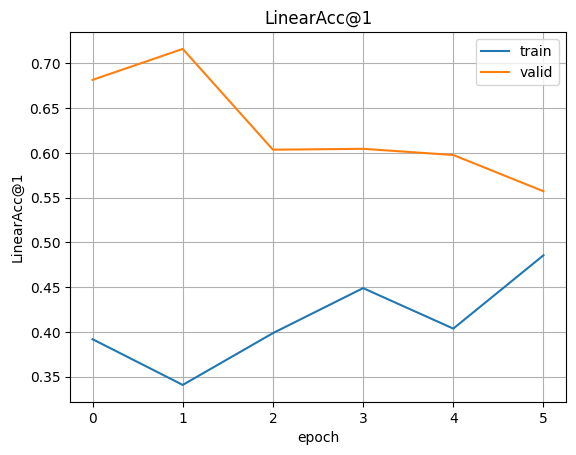

In [ ]:
plot_function( 'LinearAcc@1', history['train_linear_acc1_acc'],
                              history['valid_linear_acc1_acc']  )

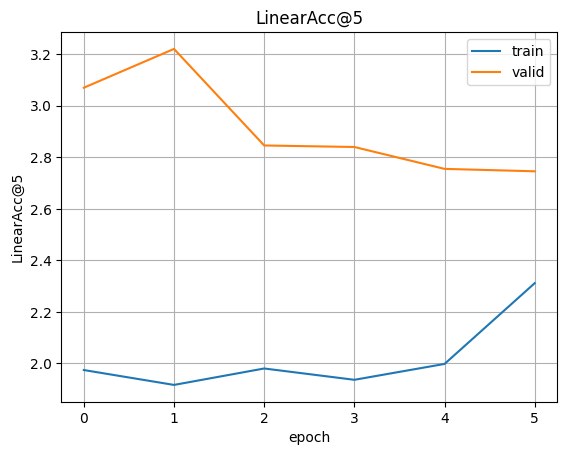

In [ ]:
plot_function( 'LinearAcc@5', history['train_linear_acc5_acc'],
                              history['valid_linear_acc5_acc']  )

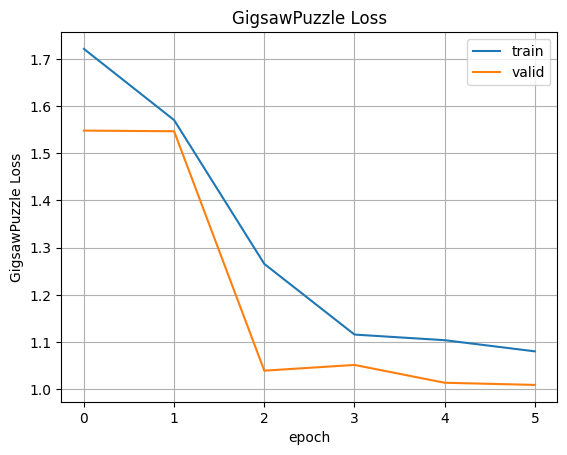

In [ ]:
plot_function( 'GigsawPuzzle Loss', history['train_loss_rot_pred'],
                                    history['valid_loss_rot_pred'] )

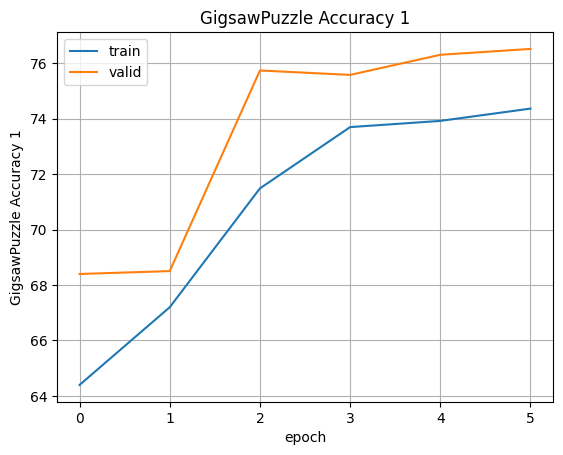

In [ ]:
plot_function( 'GigsawPuzzle Accuracy 1', history['train_acc1_rot_pred'],
                                                 history['valid_acc1_rot_pred'] )

## 12. Evaluation Utilities

In [ ]:
import torch.utils.data as data
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [ ]:
def load_model_and_data():

    ckpt_pth = osp.join( 'results', 'model_best.pth.tar' )
    ckpt     = torch.load( ckpt_pth, map_location = 'cpu' )

    model = GigsawPuzzleClassFinal( num_classes )

    model.load_state_dict(ckpt['state_dict'])

    model.cuda()
    model.eval()

    linear_classifier = model.construct_classifier()
    linear_classifier.load_state_dict( ckpt['state_dict_linear'] )

    linear_classifier.cuda()
    linear_classifier.eval()

    return model, linear_classifier

In [ ]:
def evaluate_classifier( model, linear_classifier, loader ):

    correct1, correct5 = 0, 0
    with torch.no_grad():
        for images, target, cl_target in tqdm(loader):

            images = images_to_cuda(images)

            target = target.cuda( non_blocking = True )
            cl_target = cl_target.cuda()

            out, zs = model( images, target )

            logits = linear_classifier(zs)
            acc1, acc5 = accuracy( logits, cl_target, topk = (1, 5) )

            correct1 += acc1.item() * logits.shape[0]
            correct5 += acc5.item() * logits.shape[0]

    total = len(loader.dataset)

    return correct1 / total, correct5 / total

In [ ]:
def evaluate_accuracy( model, linear_classifier, train_loader, test_loader ):

    train_acc1, train_acc5 = evaluate_classifier( model, linear_classifier, train_loader )
    test_acc1,   test_acc5 = evaluate_classifier( model, linear_classifier, test_loader )

    print('Train Set')
    print(f'Top 1 Accuracy: {train_acc1}, Top 5 Accuracy: {train_acc5}\n')
    print('Test Set')
    print(f'Top 1 Accuracy: {test_acc1}, Top 5 Accuracy: {test_acc5}\n')

In [ ]:
def images_to_cuda(images):
    if isinstance(images, (tuple, list)):
        images = [x.cuda(non_blocking=True) for x in images]
    else:
        images = images.cuda(non_blocking=True)
        return images

## Linear Classification

In [ ]:
# Load the model, a separate linear classifier, training data loader, and testing data loader
model, linear_classifier = load_model_and_data()

In [ ]:
# Evaluate the model's accuracy on the testing data
evaluate_accuracy( model, linear_classifier, train_loader, test_loader )

  0%|          | 0/57375 [00:00<?, ?it/s]

  0%|          | 0/11945 [00:00<?, ?it/s]

Train Set
Top 1 Accuracy: 0.5966013071895425, Top 5 Accuracy: 2.8494117647058825

Test Set
Top 1 Accuracy: 0.5759732105483466, Top 5 Accuracy: 2.7547090832984513

